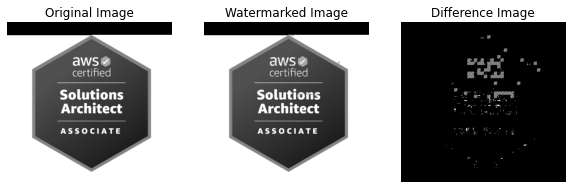

In [14]:
# Import necessary libraries
import cv2  # OpenCV library for image processing
import numpy as np  # Library for numerical computations
import matplotlib.pyplot as plt  # Library for data visualization
from scipy.fftpack import dct, idct  # Importing Discrete Cosine Transform functions from scipy

# Define a function to apply Discrete Cosine Transform (DCT) to a block
def apply_dct(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')  # Apply 2D DCT to the block and normalize it

# Define a function to apply Inverse Discrete Cosine Transform (IDCT) to a block
def apply_idct(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')  # Apply 2D IDCT to the block and normalize it

# Define a function to calculate entropy of a block
def calculate_entropy(block):
    # Calculate histogram of pixel intensities in the block
    histogram, _ = np.histogram(block, bins=256, range=(0, 256))
    # Normalize the histogram to get probabilities
    histogram_normalized = histogram / histogram.sum()
    # Calculate entropy using the formula
    entropy = -np.sum(histogram_normalized * np.log2(histogram_normalized + 1e-9))  # Avoid log(0) by adding a small value
    return entropy  # Return the entropy value

# Define a function to embed watermark into the image
def embed(image, watermark, threshold):
    h, w = image.shape  # Get the height and width of the image
    watermarked_image = np.copy(image)  # Create a copy of the original image to store the watermarked image
    watermark_index = 0  # Initialize index to keep track of watermark bits
    for i in range(0, h, 8):  # Iterate over the image in blocks of size 8x8
        for j in range(0, w, 8):
            block = image[i:i+8, j:j+8]  # Extract the current block from the image
            if calculate_entropy(block) > threshold:  # Check if block entropy exceeds the threshold
                dct_block = apply_dct(block)  # Apply DCT to the block
                if watermark_index < len(watermark):  # Check if there are watermark bits left to embed
                    # Embed watermark bit into a specific coefficient of the DCT block
                    dct_block[5, 5] += watermark[watermark_index] * 10  # Reduce change factor for subtlety
                    watermark_index += 1  # Increment watermark bit index
                watermarked_image[i:i+8, j:j+8] = apply_idct(dct_block)  # Apply IDCT and update watermarked image
    return watermarked_image  # Return the watermarked image

# Define a function to extract watermark from the watermarked image
def extract(image, threshold, watermark_size):
    h, w = image.shape  # Get the height and width of the image
    extracted_watermark = []  # Initialize list to store extracted watermark bits
    for i in range(0, h, 8):  # Iterate over the image in blocks of size 8x8
        for j in range(0, w, 8):
            block = image[i:i+8, j:j+8]  # Extract the current block from the image
            if calculate_entropy(block) > threshold:  # Check if block entropy exceeds the threshold
                dct_block = apply_dct(block)  # Apply DCT to the block
                bit = (dct_block[5, 5] % 10) > 5  # Extract watermark bit from a specific coefficient of the DCT block
                if len(extracted_watermark) < watermark_size:  # Check if all watermark bits are extracted
                    extracted_watermark.append(int(bit))  # Append the extracted watermark bit to the list
    return np.array(extracted_watermark)  # Convert extracted watermark to NumPy array and return

# Load the image in grayscale
image_path = 'C:/Users/PREDATOR/Downloads/hexagon_cutout.png'
image = cv2.imread(image_path, 0)  # Read the image in grayscale

# Check if the image is loaded properly
if image is None:
    raise ValueError(f"Image not loaded. Check the file path: {image_path}")

# Generate a random binary watermark of size 100
watermark = np.random.randint(0, 2, size=100)

# Set the threshold for entropy used in deciding where to embed watermark bits
threshold = 3.5

# Embed the watermark into the image
watermarked_image = embed(image, watermark, threshold)

# Extract the watermark from the watermarked image
extracted_watermark = extract(watermarked_image, threshold, len(watermark))

# Visualization
plt.figure(figsize=(10, 5))  # Set the figure size for visualization

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot the watermarked image+9
plt.subplot(1, 3, 2)
plt.imshow(watermarked_image, cmap='gray')
plt.title('Watermarked Image')
plt.axis('off')

# Plot the difference image (absolute difference between watermarked and original images)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(watermarked_image - image), cmap='gray')
plt.title('Difference Image')
plt.axis('off')

plt.show()  # Show the plots
